# Determing Optimal Match Number for FDR Calculations (library peak max = 31)

## Libraries, Settings, Functions

In [1]:
import pandas as pd
import re
from matplotlib import pyplot
import csodiaq_base_functions as cbf
import csodiaq_figure_functions as cff
import csodiaq_menu_functions as menu
import os
import numpy as np
from matplotlib.font_manager import FontProperties
import statistics
from matplotlib_venn import venn2
import random as rand
import math
import seaborn as sns


pd.set_option('display.max_rows', None)

In [2]:
fontP = FontProperties()
fontP.set_size(24)
filePath = 'Data/Figures/FinalFigures/'

In [62]:
def fdr_calculation(df, fdrList=False):
    # initializing the two return values at 0
    fdrValues = []
    numDecoys = 0
    df.fillna("nan",inplace=True)
    # for every row in the dataframe
    for i in range(len(df)):
        # current criteria for 'decoys' is to have 'decoy' in the protein name. This may change in the future.
        if 'DECOY' in df.loc[i]['Name']:
            numDecoys += 1
        # calculates the FDR up to this point in the data frame.
        curFDR = numDecoys/(i+1)

        # conditional statement comparing the current FDR to the FDR Cutoff. If larger, function values are returned.
        if curFDR > 0.01:

            # if the number of rows has not yet reached the minimum number that allows for the FDR cutoff, 0 is returned instead.
            if len(fdrValues) < 1/0.01:
                if fdrList: return [], 0
                else: return 0, 0
            if fdrList: return fdrValues, numDecoys-1
            else: return len(fdrValues), numDecoys-1
        fdrValues.append(curFDR)
    if fdrList: return fdrValues, numDecoys-1
    else: return len(fdrValues), numDecoys-1
    
def set_plot_settings(xlabel, ylabel, wide=True):
    
    if wide: figure = pyplot.figure(figsize=(18,12)); figure.add_axes([0.15, 0.15, 0.5, 0.75])
    else: figure = pyplot.figure(figsize=(12,12))
#    pyplot.title(title, fontsize = 40)
#    axes = pyplot.gca()
#    hx = axes.hexbin(noPool['TimeElapsed'],noPool['NumPeaks'], C=noPool['NumLibrarySpectra'])
#    cb = figure.colorbar(hx)
#    cb.set_label('Number of Library Spectra', fontsize=36, weight='bold')
#    cb.ax.tick_params(labelsize=36)
    
    pyplot.axhline(linewidth=4, color='black')
    pyplot.axvline(linewidth=4, color='black')
    pyplot.xlabel(xlabel, fontsize = 36, weight='bold')
    pyplot.ylabel(ylabel, fontsize = 36, weight='bold')
    pyplot.tick_params(axis="x", labelsize=36)
    pyplot.tick_params(axis="y", labelsize=36)

def histogram(df, fileHeader, col, l=False):
    target_scores = []
    decoy_scores = []

    temp = df.sort_values(col, ascending=False)
    temp = temp.drop_duplicates(subset='peptide', keep='first').reset_index(drop=True)

    for j in range(len(temp)):
        if 'DECOY' in temp.loc[j]['protein']: decoy_scores.append(float(temp.loc[j][col]))
        else: target_scores.append(float(temp.loc[j][col]))

    f, d = cbf.fdr_calculation(temp)
    line = temp.loc[f][col]

    pyplot.clf()
    set_plot_settings('Score', 'Frequency', wide=False)
    pyplot.hist([target_scores, decoy_scores], 50, stacked=True, density=True, label=['Target','Decoy'])
#    pyplot.gca().yaxis.set_major_formatter(PercentFormatter(1))
    if l: pyplot.axvline(x=line, color='black', linestyle = 'dashed')

In [4]:
isin = [
    'MSPLIT',
#    'Score1_match1rootXcosine, corrected',
#    'Score1_match1rootXcosine, uncorrected',
#    'Score2_match2rootXcosine, corrected',
#    'Score2_match2rootXcosine, uncorrected',
#    'Score3_match3rootXcosine, corrected',
#    'Score3_match3rootXcosine, uncorrected',
#    'Score4_match4rootXcosine, corrected',
#    'Score4_match4rootXcosine, uncorrected',
    'Score5_match5rootXcosine, corrected',
    'Score5_match5rootXcosine, uncorrected',
#    'Score6_match6rootXcosine, corrected',
#    'Score6_match6rootXcosine, uncorrected',
    'csoDIAq, corrected 6',
#    'csoDIAq, uncorrected 6',
#    'csoDIAq, corrected 31',
#    'csoDIAq, uncorrected 31',
]

## Graphs

### Overall Hits, Cosine Comparison

In [5]:
data = []

In [6]:

head = 'Data/Input/100reps_searchoutput/'
files = [head+x for x in list(os.listdir(head))]
for x in files:
    tempDf = pd.read_csv(x, sep='\t').sort_values('cosine', ascending=False).reset_index(drop=True)
    tempDf = tempDf.drop_duplicates(subset='Peptide', keep='first').reset_index(drop=True)
    run = int(re.sub('Data/Input/100reps_searchoutput/2da10ppm20200719_MAGIC_MCF7_1128repro_(\d{2,3})\.txt', r'\1', x))
    hits, decoys = fdr_calculation(tempDf)
    data.append([run, hits, tempDf.loc[hits-1]['cosine'], 'MSPLIT'])


In [7]:

head = 'Data/Output/'
files = [head+x for x in list(os.listdir(head)) if 'proteinFDR' not in x]
for x in sorted(files):
    test = re.sub('Data/Output/csodiaq_lib-human-noloss-400to2000-pt2mz-31peaks_exp-100reps-rep(\d{2,3})(_corrected)?(_\dSD)?.csv', r'\1', x)
    if test == x: continue
    run = int(re.sub('Data/Output/csodiaq_lib-human-noloss-400to2000-pt2mz-31peaks_exp-100reps-rep(\d{2,3})(_corrected)?(_\dSD)?.csv', r'\1', x))
    correct = bool(re.sub('Data/Output/csodiaq_lib-human-noloss-400to2000-pt2mz-31peaks_exp-100reps-rep(\d{2,3})(_corrected)?(_\dSD)?.csv', r'\2', x))
    print(run)
    df = pd.read_csv(x)
    scores = [y for y in list(df.columns) if re.search('match\d+rootXcosine',y)]
    for score in scores:
        tempDf = df.sort_values(score, ascending=False).reset_index(drop=True)
        tempDf = tempDf.drop_duplicates(subset='peptide', keep='first').reset_index(drop=True)
        hits, decoys = cbf.fdr_calculation(tempDf)
        tempDf = tempDf.loc[:hits+1]
        minCos = min(list(tempDf['cosine']))
        if correct: data.append([run, hits, minCos, score + ', corrected'])
        else: data.append([run, hits, minCos, score + ', uncorrected'])


1
1
2
2
3
3
4
4
5
5
6
6
7
7
8
8
9
9
10
100
100
10
11
11
12
12
13
13
14
14
15
15
16
16
17
17
18
18
19
19
20
20
21
21
22
22
23
23
24
24
25
25
26
26
27
27
28
28
29
29
30
30
31
31
32
32
33
33
34
34
35
35
36
36
37
37
38
38
39
39
40
40
41
41
42
42
43
43
44
44
45
45
46
46
47
47
48
48
49
49
50
50
51
51
52
52
53
53
54
54
55
55
56
56
57
57
58
58
59
59
60
60
61
61
62
62
63
63
64
64
65
65
66
66
67
67
68
68
69
69
70
70
71
71
72
72
73
73
74
74
75
75
76
76
77
77
78
78
79
79
80
80
81
81
82
82
83
83
84
84
85
85
86
86
87
87
88
88
89
89
90
90
91
91
92
92
93
93
94
94
95
95
96
96
97
97
98
98
99
99


In [8]:

scoreDf = pd.DataFrame(data, columns = ['run','num of hits', 'cosine', 'type'])
scoreDf = scoreDf.sort_values(['run', 'type']).reset_index(drop=True)
scoreDf


run  num of hits    cosine                                   type
0       1         1512  0.705036                                 MSPLIT
1       1         2677  0.620335    Score1_match1rootXcosine, corrected
2       1         1314  0.726844  Score1_match1rootXcosine, uncorrected
3       1         2870  0.726844    Score2_match2rootXcosine, corrected
4       1         1281  0.776932  Score2_match2rootXcosine, uncorrected
5       1         2856  0.799900    Score3_match3rootXcosine, corrected
6       1         1854  0.822455  Score3_match3rootXcosine, uncorrected
7       1         2973  0.800879    Score4_match4rootXcosine, corrected
8       1         1823  0.856747  Score4_match4rootXcosine, uncorrected
9       1         3044  0.854472    Score5_match5rootXcosine, corrected
10      1         1893  0.856747  Score5_match5rootXcosine, uncorrected
11      1         3012  0.856289    Score6_match6rootXcosine, corrected
12      1         1868  0.866332  Score6_match6rootXcosine, uncorrected
13      2         1525  0.705010                                 MSPLIT
14      2         2970  0.678852    Score1_match1rootXcosine, corrected
15      2         1638  0.678852  Score1_match1rootXcosine, uncorrected
16      2         2972  0.678852    Score2_match2rootXcosine, corrected
17      2         2044  0.747202  Score2_match2rootXcosine, uncorrected
18      2         2967  0.822739    Score3_match3rootXcosine, corrected
19      2         2153  0.838567  Score3_match3rootXcosine, uncorrected
20      2         2896  0.839889    Score4_match4rootXcosine, corrected
21      2         2185  0.838567  Score4_match4rootXcosine, uncorrected
22      2         2772  0.852784    Score5_match5rootXcosine, corrected
23      2         1996  0.857889  Score5_match5rootXcosine, uncorrected
24      2         2775  0.857889    Score6_match6rootXcosine, corrected
25      2         1986  0.857889  Score6_match6rootXcosine, uncorrected
26      3         1555  0.705073                                 MSPLIT
27      3         3070  0.686944    Score1_match1rootXcosine, corrected
28      3         1629  0.726113  Score1_match1rootXcosine, uncorrected
29      3         3054  0.726113    Score2_match2rootXcosine, corrected
30      3         1991  0.726113  Score2_match2rootXcosine, uncorrected
31      3         3015  0.812752    Score3_match3rootXcosine, corrected
32      3         2085  0.819354  Score3_match3rootXcosine, uncorrected
33      3         3136  0.828018    Score4_match4rootXcosine, corrected
34      3         2093  0.828018  Score4_match4rootXcosine, uncorrected
35      3         3084  0.828018    Score5_match5rootXcosine, corrected
36      3         2195  0.868905  Score5_match5rootXcosine, uncorrected
37      3         3138  0.868924    Score6_match6rootXcosine, corrected
38      3         2268  0.868905  Score6_match6rootXcosine, uncorrected
39      4         1592  0.705161                                 MSPLIT
40      4         3080  0.630997    Score1_match1rootXcosine, corrected
41      4         1574  0.725700  Score1_match1rootXcosine, uncorrected
42      4         3089  0.731070    Score2_match2rootXcosine, corrected
43      4         1569  0.800835  Score2_match2rootXcosine, uncorrected
44      4         3077  0.822689    Score3_match3rootXcosine, corrected
45      4         2059  0.832658  Score3_match3rootXcosine, uncorrected
46      4         3034  0.826035    Score4_match4rootXcosine, corrected
47      4         2160  0.834756  Score4_match4rootXcosine, uncorrected
48      4         3016  0.868311    Score5_match5rootXcosine, corrected
49      4         2148  0.871199  Score5_match5rootXcosine, uncorrected
50      4         3034  0.871199    Score6_match6rootXcosine, corrected
51      4         2121  0.874793  Score6_match6rootXcosine, uncorrected
52      5         1559  0.705132                                 MSPLIT
53      5         3078  0.666476    Score1_match1rootXcosine, corrected
54      5         1686  0.666476  Score1_match

In [9]:

# Adding in the old results for comparison
oldDf = pd.read_csv('Data/MSPLIT_csoDIAq_100repCompare_peptide_lib31_raw.csv')
scoreDf = pd.concat([scoreDf, oldDf]).drop_duplicates(keep='first').reset_index(drop=True)
scoreDf = scoreDf.loc[:, scoreDf.columns.intersection(['run','num of hits', 'cosine', 'type'])].drop_duplicates(keep='first').reset_index(drop=True)
scoreDf


run  num of hits    cosine                                   type
0       1       1512.0  0.705036                                 MSPLIT
1       1       2677.0  0.620335    Score1_match1rootXcosine, corrected
2       1       1314.0  0.726844  Score1_match1rootXcosine, uncorrected
3       1       2870.0  0.726844    Score2_match2rootXcosine, corrected
4       1       1281.0  0.776932  Score2_match2rootXcosine, uncorrected
5       1       2856.0  0.799900    Score3_match3rootXcosine, corrected
6       1       1854.0  0.822455  Score3_match3rootXcosine, uncorrected
7       1       2973.0  0.800879    Score4_match4rootXcosine, corrected
8       1       1823.0  0.856747  Score4_match4rootXcosine, uncorrected
9       1       3044.0  0.854472    Score5_match5rootXcosine, corrected
10      1       1893.0  0.856747  Score5_match5rootXcosine, uncorrected
11      1       3012.0  0.856289    Score6_match6rootXcosine, corrected
12      1       1868.0  0.866332  Score6_match6rootXcosine, uncorrected
13      2       1525.0  0.705010                                 MSPLIT
14      2       2970.0  0.678852    Score1_match1rootXcosine, corrected
15      2       1638.0  0.678852  Score1_match1rootXcosine, uncorrected
16      2       2972.0  0.678852    Score2_match2rootXcosine, corrected
17      2       2044.0  0.747202  Score2_match2rootXcosine, uncorrected
18      2       2967.0  0.822739    Score3_match3rootXcosine, corrected
19      2       2153.0  0.838567  Score3_match3rootXcosine, uncorrected
20      2       2896.0  0.839889    Score4_match4rootXcosine, corrected
21      2       2185.0  0.838567  Score4_match4rootXcosine, uncorrected
22      2       2772.0  0.852784    Score5_match5rootXcosine, corrected
23      2       1996.0  0.857889  Score5_match5rootXcosine, uncorrected
24      2       2775.0  0.857889    Score6_match6rootXcosine, corrected
25      2       1986.0  0.857889  Score6_match6rootXcosine, uncorrected
26      3       1555.0  0.705073                                 MSPLIT
27      3       3070.0  0.686944    Score1_match1rootXcosine, corrected
28      3       1629.0  0.726113  Score1_match1rootXcosine, uncorrected
29      3       3054.0  0.726113    Score2_match2rootXcosine, corrected
30      3       1991.0  0.726113  Score2_match2rootXcosine, uncorrected
31      3       3015.0  0.812752    Score3_match3rootXcosine, corrected
32      3       2085.0  0.819354  Score3_match3rootXcosine, uncorrected
33      3       3136.0  0.828018    Score4_match4rootXcosine, corrected
34      3       2093.0  0.828018  Score4_match4rootXcosine, uncorrected
35      3       3084.0  0.828018    Score5_match5rootXcosine, corrected
36      3       2195.0  0.868905  Score5_match5rootXcosine, uncorrected
37      3       3138.0  0.868924    Score6_match6rootXcosine, corrected
38      3       2268.0  0.868905  Score6_match6rootXcosine, uncorrected
39      4       1592.0  0.705161                                 MSPLIT
40      4       3080.0  0.630997    Score1_match1rootXcosine, corrected
41      4       1574.0  0.725700  Score1_match1rootXcosine, uncorrected
42      4       3089.0  0.731070    Score2_match2rootXcosine, corrected
43      4       1569.0  0.800835  Score2_match2rootXcosine, uncorrected
44      4       3077.0  0.822689    Score3_match3rootXcosine, corrected
45      4       2059.0  0.832658  Score3_match3rootXcosine, uncorrected
46      4       3034.0  0.826035    Score4_match4rootXcosine, corrected
47      4       2160.0  0.834756  Score4_match4rootXcosine, uncorrected
48      4       3016.0  0.868311    Score5_match5rootXcosine, corrected
49      4       2148.0  0.871199  Score5_match5rootXcosine, uncorrected
50      4       3034.0  0.871199    Score6_match6rootXcosine, corrected
51      4       2121.0  0.874793  Score6_match6rootXcosine, uncorrected
52      5       1559.0  0.705132                                 MSPLIT
53      5       3078.0  0.666476    Score1_match1rootXcosine, corrected
54      5       1686.0  0.666476  Score1_match

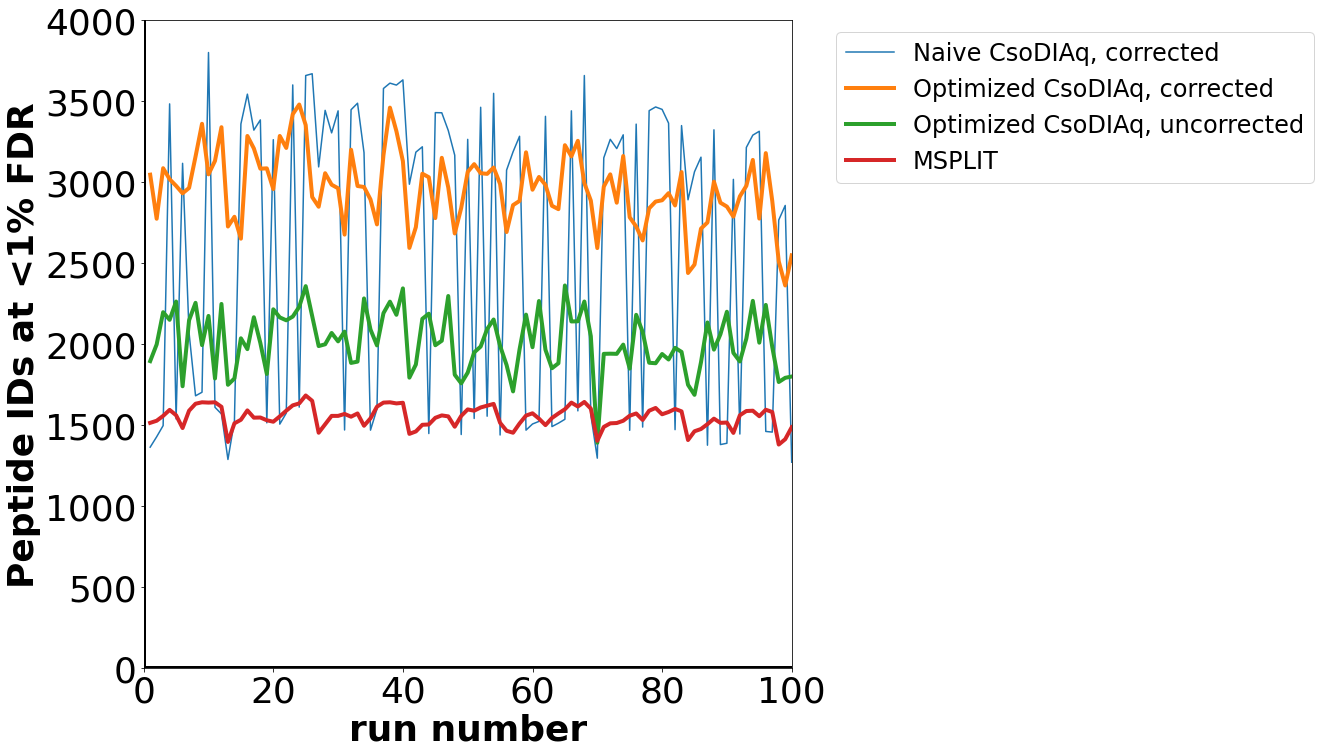

In [10]:
tempDf = scoreDf[scoreDf.type.isin(isin)]
graph = tempDf.pivot(index='run', columns='type', values='num of hits')
set_plot_settings('run number', 'Peptide IDs at <1% FDR')
pyplot.plot(graph.index,graph['csoDIAq, corrected 6'], label='Naive CsoDIAq, corrected')
pyplot.plot(graph.index,graph['Score5_match5rootXcosine, corrected'],lw=4, label='Optimized CsoDIAq, corrected')
pyplot.plot(graph.index,graph['Score5_match5rootXcosine, uncorrected'],lw=4, label='Optimized CsoDIAq, uncorrected')
pyplot.plot(graph.index,graph['MSPLIT'],lw=4, label='MSPLIT')

#for x in graph.columns:
#    pyplot.plot(graph.index,graph[x], label=x)
pyplot.legend(bbox_to_anchor=(1.05, 1), loc='upper left', prop=fontP)
axes = pyplot.gca()
pyplot.xlim(0,100)
pyplot.ylim(0,4000)
pyplot.savefig(filePath+'LineGraph_PeptideHitsAboveFDR.svg')
pyplot.savefig(filePath+'LineGraph_PeptideHitsAboveFDR.png')
pyplot.show()

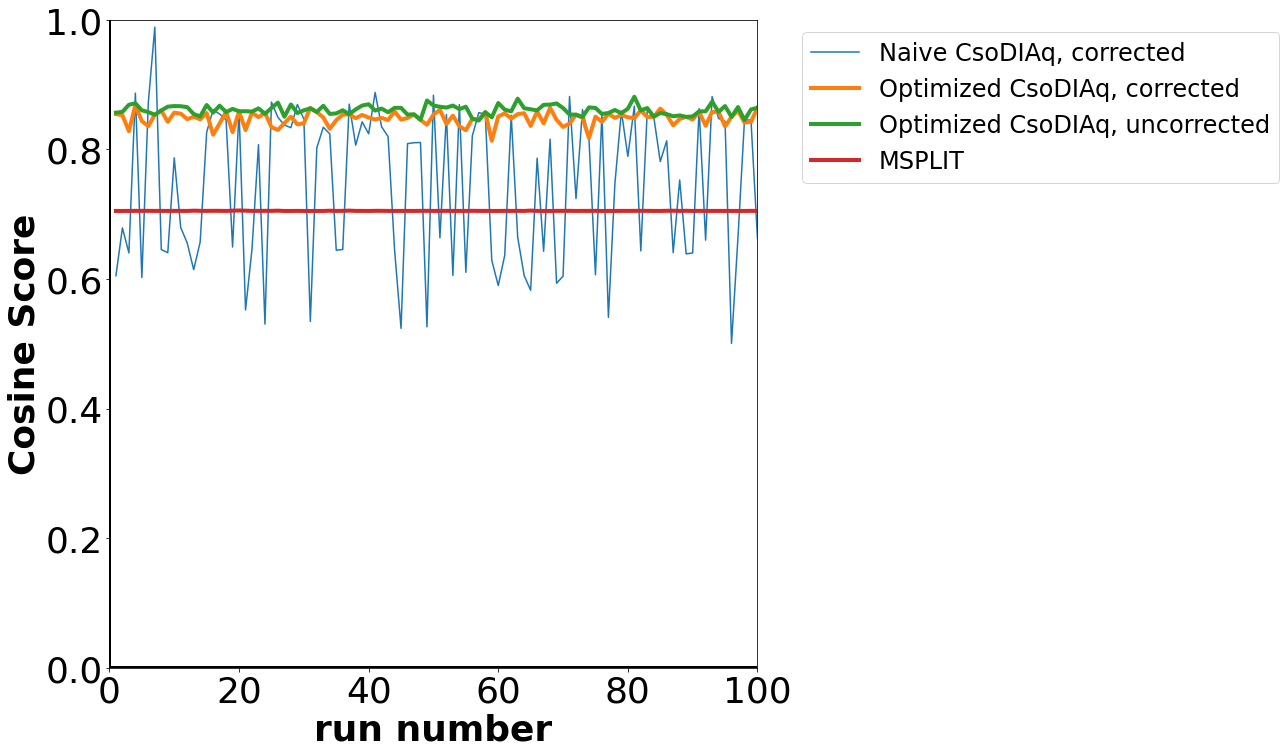

In [11]:
tempDf = scoreDf[scoreDf.type.isin(isin)]
graph = tempDf.pivot(index='run', columns='type', values='cosine')
set_plot_settings('run number', 'Cosine Score')
pyplot.plot(graph.index,graph['csoDIAq, corrected 6'], label='Naive CsoDIAq, corrected')
pyplot.plot(graph.index,graph['Score5_match5rootXcosine, corrected'],lw=4, label='Optimized CsoDIAq, corrected')
pyplot.plot(graph.index,graph['Score5_match5rootXcosine, uncorrected'],lw=4, label='Optimized CsoDIAq, uncorrected')
pyplot.plot(graph.index,graph['MSPLIT'],lw=4, label='MSPLIT')

#for x in graph.columns:
#    pyplot.plot(graph.index,graph[x], label=x)
pyplot.legend(bbox_to_anchor=(1.05, 1), loc='upper left', prop=fontP)
axes = pyplot.gca()
pyplot.ylim(0,1)
pyplot.xlim(0,100)

pyplot.savefig(filePath+'LineGraph_PeptideMinCosineAboveFDR.svg')
pyplot.savefig(filePath+'LineGraph_PeptideMinCosineAboveFDR.png')
pyplot.show()

In [12]:
proteins = []
head = 'Data/Output/'
files = [head+x for x in list(os.listdir(head)) if 'proteinFDR' in x]

for x in sorted(files):
    df = pd.read_csv(x)
    test = re.sub('Data/Output/csodiaq_lib-human-noloss-400to2000-pt2mz-31peaks_exp-100reps-rep(\d{2,3})(_corrected)?(_\dSD)?_proteinFDR\.csv', r'\1', x)
    if test == x: continue
    run = int(re.sub('Data/Output/csodiaq_lib-human-noloss-400to2000-pt2mz-31peaks_exp-100reps-rep(\d{2,3})(_corrected)?(_\dSD)?_proteinFDR\.csv', r'\1', x))
    correct = bool(re.sub('Data/Output/csodiaq_lib-human-noloss-400to2000-pt2mz-31peaks_exp-100reps-rep(\d{2,3})(_corrected)?(_\dSD)?_proteinFDR\.csv', r'\2', x))
    hits = len(set(df['leadingProtein']))
    proteins.append([run, hits, correct])
    
protDf = pd.DataFrame(proteins, columns = ['run','num of hits', 'type'])
protDf
    

run  num of hits   type
0      1          707   True
1      1          374  False
2      2          745   True
3      2          478  False
4      3          776   True
5      3          635  False
6      4          788   True
7      4          554  False
8      5          755   True
9      5          633  False
10     6          732   True
11     6          369  False
12     7          758   True
13     7          533  False
14     8          748   True
15     8          539  False
16     9          860   True
17     9          601  False
18   100          592   True
19   100          440  False
20    10          773   True
21    10          535  False
22    11          743   True
23    11          479  False
24    12          825   True
25    12          551  False
26    13          681   True
27    13          509  False
28    14          738   True
29    14          491  False
30    15          723   True
31    15          493  False
32    16          740   True
33    16          544  False
34    17          694   True
35    17          550  False
36    18          774   True
37    18          492  False
38    19          823   True
39    19          487  False
40    20          678   True
41    20          560  False
42    21          757   True
43    21          630  False
44    22          654   True
45    22          447  False
46    23          833   True
47    23          545  False
48    24          874   True
49    24          595  False
50    25          820   True
51    25          631  False
52    26          745   True
53    26          560  False
54    27          754   True
55    27          581  False
56    28          809   True
57    28          597  False
58    29          710   True
59    29          487  False
60    30          694   True
61    30          470  False
62    31          679   True
63    31          584  False
64    32          786   True
65    32          509  False
66    33          694   True
67    33          526  False
68    34          756   True
69    34          491  False
70    35          670   True
71    35          491  False
72    36          747   True
73    36          452  False
74    37          739   True
75    37          545  False
76    38          629   True
77    38          525  False
78    39          796   True
79    39          584  False
80    40          763   True
81    40          608  False
82    41          664   True
83    41          458  False
84    42          703   True
85    42          560  False
86    43          755   True
87    43          576  False
88    44          697   True
89    44          657  False
90    45          729   True
91    45          546  False
92    46          796   True
93    46          578  False
94    47          721   True
95    47          577  False
96    48          657   True
97    48          525  False
98    49          681   True
99    49          441  False
100   50          711   True
101   50          474  False
102   51          808   True
103   51          530  False
104   52          779   True
105   52          541  False
106   53          665   True
107   53          625  False
108   54          711   True
109   54          546  False
110   55          772   True
111   55          553  False
112   56          667   True
113   56          554  False
114   57          698   True
115   57          568  False
116   58          596   True
117   58          551  False
118   59          680   True
119   59          484  False
120   60          725   True
121   60          562  False
122   61          677   True
123   61          612  False
124   62          809   True
125   62          521  False
126   63          754   True
127   63          476  False
128   64          639   True
129   64          516  False
130   65          789   True
131   65          567  False
132   66          764   True
133   66          490  False
134   67          691   True
135   67          584  False
136   68          696   True
137

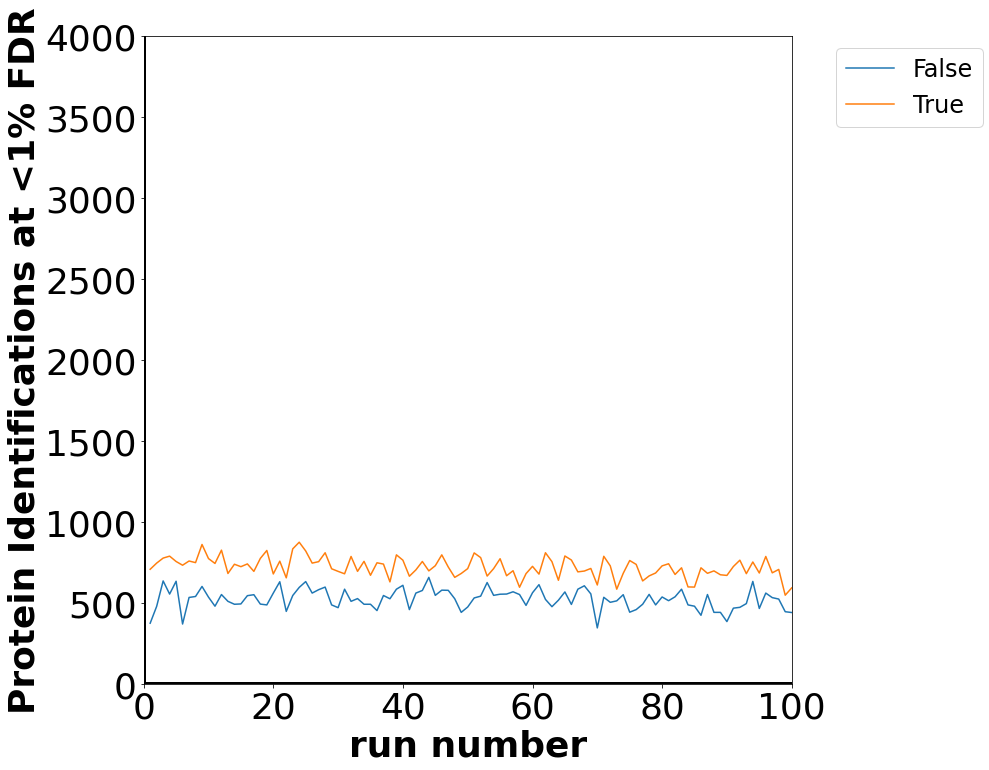

In [13]:
graph = protDf.pivot(index='run', columns='type', values='num of hits')
set_plot_settings('run number', 'Protein Identifications at <1% FDR')
for x in graph.columns:
    pyplot.plot(graph.index,graph[x], label=x)
pyplot.legend(bbox_to_anchor=(1.05, 1), loc='upper left', prop=fontP)
axes = pyplot.gca()
pyplot.ylim(0,4000)
pyplot.xlim(0,100)


pyplot.savefig(filePath+'LineGraph_ProteinHitsAboveFDR.svg')
pyplot.savefig(filePath+'LineGraph_ProteinHitsAboveFDR.png')
pyplot.show()

In [14]:
print('Average # peptides, MSPLIT:')
tempDf = scoreDf[scoreDf['type']=='MSPLIT']
v = list(tempDf['num of hits'])
print(sum(v)/len(v))
print('standard deviation:' + str(statistics.pstdev(v)) + '\n')

print('Average # peptides, uncorrected, score 5:')
tempDf = scoreDf[scoreDf['type']=='Score5_match5rootXcosine, uncorrected']
v = list(tempDf['num of hits'])
print(sum(v)/len(v))
print('standard deviation:' + str(statistics.pstdev(v)) + '\n')

print('Average # peptides, corrected, score 5:')
tempDf = scoreDf[scoreDf['type']=='Score5_match5rootXcosine, corrected']
v = list(tempDf['num of hits'])
print(sum(v)/len(v))
print('standard deviation:' + str(statistics.pstdev(v)) + '\n')

print('Average # peptides, uncorrected, score 4:')
tempDf = scoreDf[scoreDf['type']=='Score4_match4rootXcosine, uncorrected']
v = list(tempDf['num of hits'])
print(sum(v)/len(v))
print('standard deviation:' + str(statistics.pstdev(v)) + '\n')

print('Average # peptides, corrected, score 4:')
tempDf = scoreDf[scoreDf['type']=='Score4_match4rootXcosine, corrected']
v = list(tempDf['num of hits'])
print(sum(v)/len(v))
print('standard deviation:' + str(statistics.pstdev(v)) + '\n')

print('Average # proteins, corrected, score 5:')
tempDf = protDf[protDf['type']==True]
v = list(tempDf['num of hits'])
print(sum(v)/len(v))
print('standard deviation:' + str(statistics.pstdev(v)) + '\n')

print('Average # proteins, uncorrected, score 5:')
tempDf = protDf[protDf['type']==False]
v = list(tempDf['num of hits'])
print(sum(v)/len(v))
print('standard deviation:' + str(statistics.pstdev(v)) + '\n')


Average # peptides, MSPLIT:
1549.13
standard deviation:63.60764969718658

Average # peptides, uncorrected, score 5:
2016.87
standard deviation:177.28618981748127

Average # peptides, corrected, score 5:
2958.52
standard deviation:224.07674935164513

Average # peptides, uncorrected, score 4:
2003.27
standard deviation:185.3397882269212

Average # peptides, corrected, score 4:
2988.99
standard deviation:227.46109535478809

Average # proteins, corrected, score 5:
720.01
standard deviation:61.7544322295979

Average # proteins, uncorrected, score 5:
523.78
standard deviation:61.71232940020981



## Histograms

In [15]:
peptideFDR = pd.read_csv('Data/Output/csodiaq_lib-human-noloss-400to2000-pt2mz-31peaks_exp-100reps-rep24_corrected_2SD.csv')
h = 'Data/Figures/testScoreHistogram_newScore_'

<Figure size 432x288 with 0 Axes>

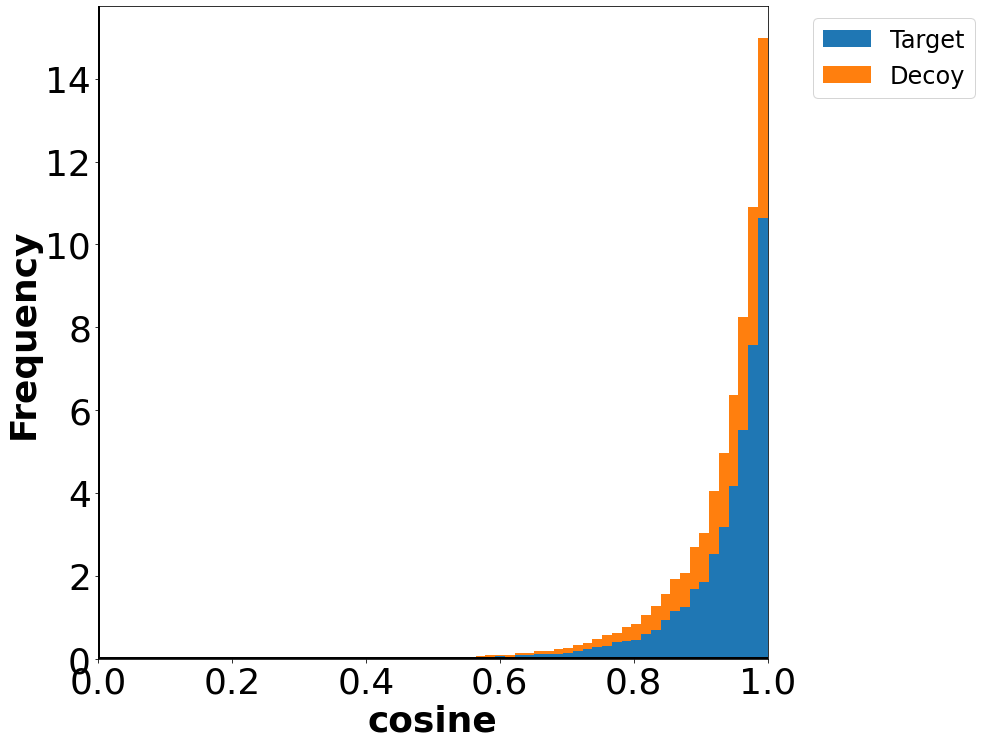

In [16]:
histogram(peptideFDR, h, 'cosine')
pyplot.legend(bbox_to_anchor=(1.05, 1), loc='upper left', prop=fontP)
pyplot.savefig(filePath+'Histogram_CosineDistribution.svg')
pyplot.savefig(filePath+'Histogram_CosineDistribution.png')
pyplot.xlim(0, 1)

pyplot.show()

<ipython-input-17-fdb8c2eae0dc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  decoyDf['shared'] = decoyDf['shared'].apply(lambda x: x+0.14)
<ipython-input-17-fdb8c2eae0dc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targetDf['shared'] = targetDf['shared'].apply(lambda x: x-0.14)


(0.0, 1.0)

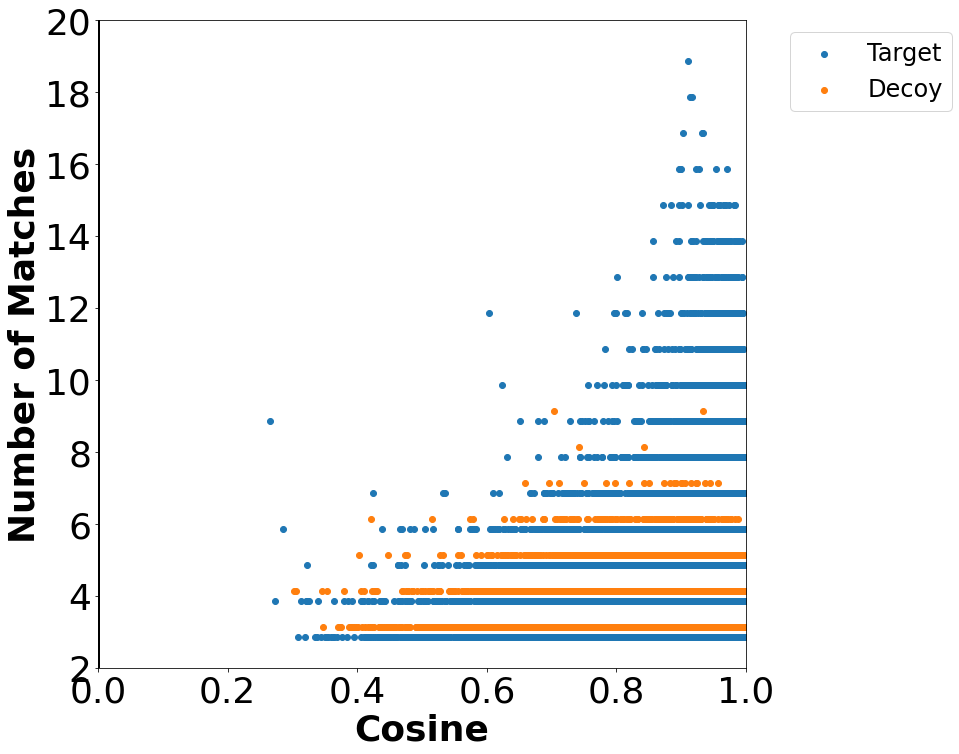

In [17]:


decoyDf = peptideFDR[peptideFDR['protein'].str.contains('DECOY')]
targetDf = peptideFDR[~peptideFDR['protein'].str.contains('DECOY')]
decoyDf['shared'] = decoyDf['shared'].apply(lambda x: x+0.14)
targetDf['shared'] = targetDf['shared'].apply(lambda x: x-0.14)
set_plot_settings('Cosine', 'Number of Matches')
#decoyDf.plot.scatter('cosine','shared')
pyplot.scatter(targetDf['cosine'],targetDf['shared'], label = 'Target')
pyplot.scatter(decoyDf['cosine'],decoyDf['shared'], label = 'Decoy')
#pyplot.scatter(noPool['TimeElapsed'],noPool['NumPeaks'], label='No Pooling')
pyplot.legend(bbox_to_anchor=(1.05, 1), loc='upper left', prop=fontP)
pyplot.ylim(2,20)
pyplot.xlim(0,1)

<ipython-input-18-9b9cac4525f8>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  decoyDf['shared'] = decoyDf['shared'].apply(lambda x: x+0.14)
<ipython-input-18-9b9cac4525f8>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targetDf['shared'] = targetDf['shared'].apply(lambda x: x-0.14)


(0.0, 1.0)

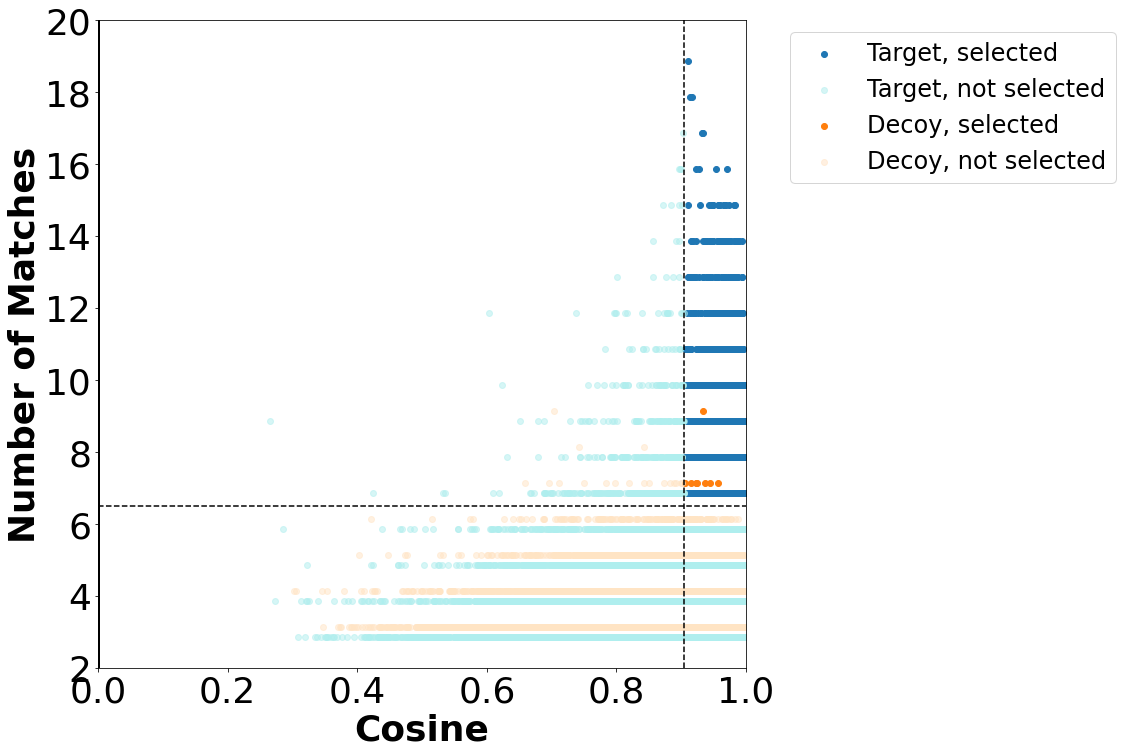

In [18]:
tempDf = peptideFDR[peptideFDR['shared'] > 5].reset_index(drop=True)
tempDf = tempDf.sort_values('cosine', ascending=False).reset_index(drop=True)
hits, decoys = cbf.fdr_calculation(tempDf)
lowCosine = tempDf.loc[hits-1]['cosine']
lowShared = 6.5




decoyDf = peptideFDR[peptideFDR['protein'].str.contains('DECOY')]
targetDf = peptideFDR[~peptideFDR['protein'].str.contains('DECOY')]
decoyDf['shared'] = decoyDf['shared'].apply(lambda x: x+0.14)
targetDf['shared'] = targetDf['shared'].apply(lambda x: x-0.14)

dHits = decoyDf[(decoyDf['cosine'] >= lowCosine) & (decoyDf['shared'] > lowShared)]
dMisses = decoyDf[(decoyDf['cosine'] < lowCosine) | (decoyDf['shared'] < lowShared)]
tHits = targetDf[(targetDf['cosine'] >= lowCosine) & (targetDf['shared'] > lowShared)]
tMisses = targetDf[(targetDf['cosine'] < lowCosine) | (targetDf['shared'] < lowShared)]




set_plot_settings('Cosine', 'Number of Matches')


pyplot.scatter(tHits['cosine'],tHits['shared'], label = 'Target, selected')
pyplot.scatter(tMisses['cosine'],tMisses['shared'], color='#AFEEEE', label = 'Target, not selected', alpha=0.5)
pyplot.scatter(dHits['cosine'],dHits['shared'], label = 'Decoy, selected')
pyplot.scatter(dMisses['cosine'],dMisses['shared'], color='#FFE4C4', label = 'Decoy, not selected', alpha=0.5)


pyplot.axhline(y=lowShared, color='black', linestyle = 'dashed')
pyplot.axvline(x=lowCosine, color='black', linestyle = 'dashed')
pyplot.legend(bbox_to_anchor=(1.05, 1), loc='upper left', prop=fontP)
pyplot.ylim(2,20)
pyplot.xlim(0,1)

<ipython-input-19-02554d0101cc>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  decoyDf['shared'] = decoyDf['shared'].apply(lambda x: x+0.14)
<ipython-input-19-02554d0101cc>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targetDf['shared'] = targetDf['shared'].apply(lambda x: x-0.14)


(0.0, 1.0)

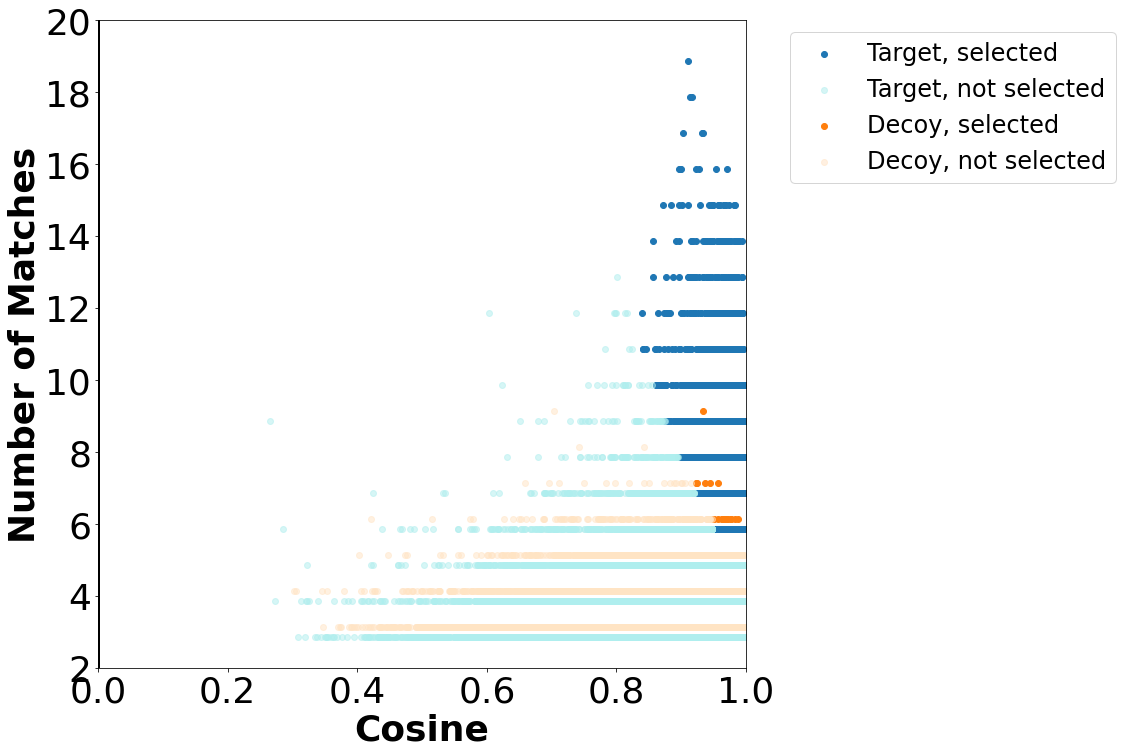

In [19]:
score = 'Score5_match5rootXcosine'
tempDf = peptideFDR.sort_values(score, ascending=False).reset_index(drop=True)
hits, decoys = cbf.fdr_calculation(tempDf)
lowCosine = tempDf.loc[hits-1][score]
lowShared = 5.5




decoyDf = peptideFDR[peptideFDR['protein'].str.contains('DECOY')]
targetDf = peptideFDR[~peptideFDR['protein'].str.contains('DECOY')]
decoyDf['shared'] = decoyDf['shared'].apply(lambda x: x+0.14)
targetDf['shared'] = targetDf['shared'].apply(lambda x: x-0.14)

dHits = decoyDf[(decoyDf[score] >= lowCosine) & (decoyDf['shared'] > lowShared)]
dMisses = decoyDf[(decoyDf[score] < lowCosine) | (decoyDf['shared'] < lowShared)]
tHits = targetDf[(targetDf[score] >= lowCosine) & (targetDf['shared'] > lowShared)]
tMisses = targetDf[(targetDf[score] < lowCosine) | (targetDf['shared'] < lowShared)]




set_plot_settings('Cosine', 'Number of Matches')


pyplot.scatter(tHits['cosine'],tHits['shared'], label = 'Target, selected')
pyplot.scatter(tMisses['cosine'],tMisses['shared'], color='#AFEEEE', label = 'Target, not selected', alpha=0.5)
pyplot.scatter(dHits['cosine'],dHits['shared'], label = 'Decoy, selected')
pyplot.scatter(dMisses['cosine'],dMisses['shared'], color='#FFE4C4', label = 'Decoy, not selected', alpha=0.5)


pyplot.legend(bbox_to_anchor=(1.05, 1), loc='upper left', prop=fontP)
pyplot.ylim(2,20)
pyplot.xlim(0,1)

<Figure size 432x288 with 0 Axes>

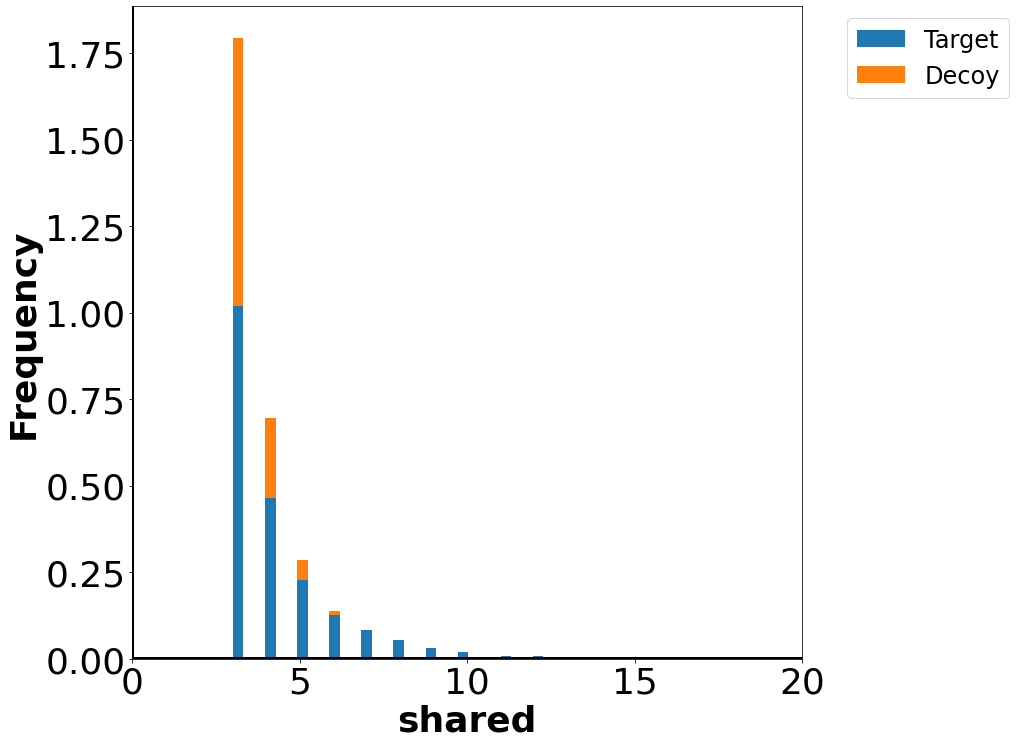

In [20]:
histogram(peptideFDR, h, 'shared')
pyplot.legend(bbox_to_anchor=(1.05, 1), loc='upper left', prop=fontP)
pyplot.savefig(filePath+'Histogram_FragmentCountDistribution.svg')
pyplot.savefig(filePath+'Histogram_FragmentCountDistribution.png')
pyplot.xlim(0, 20)
pyplot.show()

<Figure size 432x288 with 0 Axes>

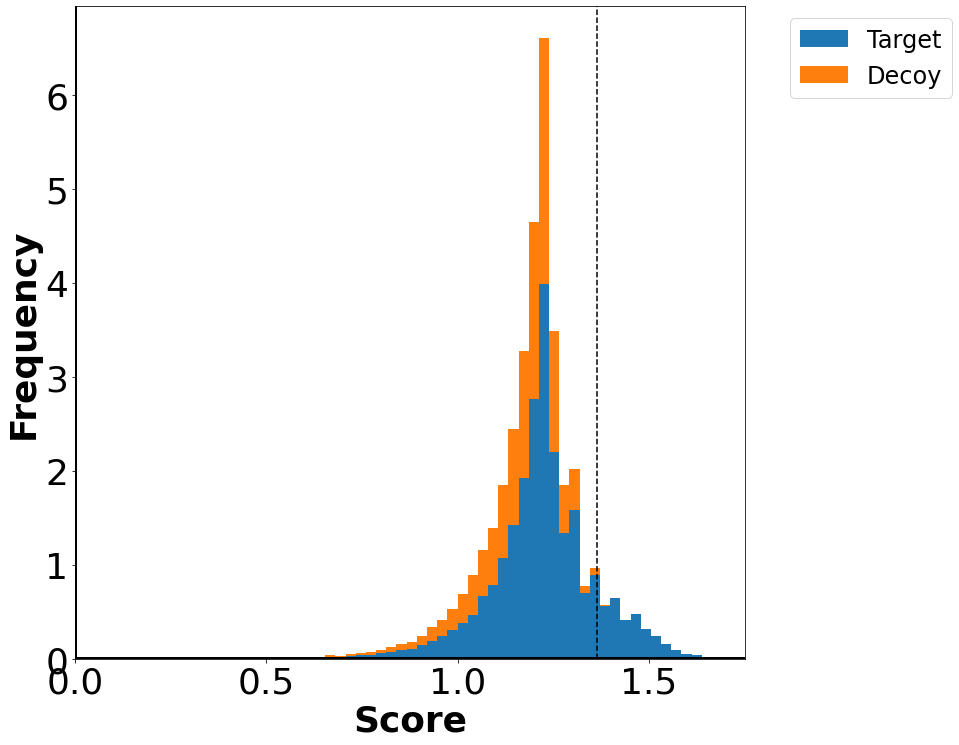

<Figure size 432x288 with 0 Axes>

In [63]:
histogram(peptideFDR, h, 'Score5_match5rootXcosine', l=True)
pyplot.legend(bbox_to_anchor=(1.05, 1), loc='upper left', prop=fontP)
pyplot.savefig(filePath+'Histogram_csoDIAqScoreDistribution.svg')
pyplot.savefig(filePath+'Histogram_csoDIAqScoreDistribution.png')
pyplot.xlim(0, 1.75)
pyplot.show()
pyplot.savefig('Figure1-6.svg')

## Time Graphs

In [22]:
noPool = pd.read_csv('Data/TimeGraphs/lib-human-6_exp-n1b_timeGraph_every1Peak_noPool.csv', comment='#')
noPool

Index  TimeElapsed  NumPeaks  ExpPrecursorMz  NumLibrarySpectra  \
0         1     2.503178        98           401.0                300   
1         2     0.544647       115           402.0                280   
2         3     0.600097       112           403.0                293   
3         4     0.616807       141           404.0                352   
4         5     1.261006       129           405.0                392   
5         6     0.961756       122           406.0                364   
6         7     0.888973       148           407.0                333   
7         8     1.244013       165           408.0                319   
8         9     1.004497       151           409.0                304   
9        10     0.929085       125           410.0                346   
10       11     0.844786       113           411.0                374   
11       12     1.124854       107           412.0                388   
12       13     1.254088       124           413.0                382   
13       14     0.923489       128           414.0                389   
14       15     1.316989       111           415.0                400   
15       16     0.987962       101           416.0                383   
16       17     0.880408        98           417.0                404   
17       18     1.186949        98           418.0                411   
18       19     0.837589        94           419.0                425   
19       20     0.870111       106           420.0                434   
20       21     1.248516       125           421.0                417   
21       22     1.029374       161           422.0                400   
22       23     1.303290       155           423.0                397   
23       24     1.841167       150           424.0                418   
24       25     1.359675       150           425.0                417   
25       26     1.334830       131           426.0                401   
26       27     1.756085       113           427.0                401   
27       28     0.948845       130           428.0                435   
28       29     1.430930       122           429.0                467   
29       30     1.260536       156           430.0                466   
30       31     1.341719       145           431.0                453   
31       32     1.666509       148           432.0                493   
32       33     1.771862       108           433.0                517   
33       34     1.520254       104           434.0                505   
34       35     1.461495       127           435.0                539   
35       36     1.633450       115           436.0                594   
36       37     2.012535       102           437.0                560   
37       38     1.502126       133           438.0                533   
38       39     1.668287       150           439.0                549   
39       40     2.159623       126           440.0                492   
40       41     1.231795       129           441.0                492   
41       42     1.695724        99           442.0                549   
42       43     1.472447       102           443.0                566   
43       44     1.433947       118           444.0                592   
44       45     1.913747       141           445.0                582   
45       46     1.812037       134           446.0                537   
46       47     1.611648       151           447.0                572   
47       48     2.158726       170           448.0                597   
48       49     2.140658       145           449.0                589   
49       50     1.874773       131           450.0                562   
50       51     2.028980       105           451.0                560   
51       52     1.527156       102           452.0                618   
52       53     1.961584       106           453.0                633   
53       54     1.721982       100           454.0              

In [23]:
pool = pd.read_csv('Data/TimeGraphs/lib-human-20_exp-n1b_timeGraph_every1Peak.csv', comment='#')
pool

Index  TimeElapsed  NumPeaks  ExpPrecursorMz  NumLibrarySpectra  \
0         1     2.455936        98           401.0                300   
1         2     0.047135       115           402.0                280   
2         3     0.040138       112           403.0                293   
3         4     0.056135       141           404.0                352   
4         5     0.050626       129           405.0                392   
5         6     0.049330       122           406.0                364   
6         7     0.046137       148           407.0                333   
7         8     0.052345       165           408.0                319   
8         9     0.042900       151           409.0                304   
9        10     0.042873       125           410.0                346   
10       11     0.044680       113           411.0                374   
11       12     0.046400       107           412.0                388   
12       13     0.046526       124           413.0                382   
13       14     0.056375       128           414.0                389   
14       15     0.046761       111           415.0                400   
15       16     0.045704       101           416.0                383   
16       17     0.046333        98           417.0                404   
17       18     0.048905        98           418.0                411   
18       19     0.053703        94           419.0                425   
19       20     0.053193       106           420.0                434   
20       21     0.048863       125           421.0                417   
21       22     0.048559       161           422.0                400   
22       23     0.047634       155           423.0                397   
23       24     0.057499       150           424.0                418   
24       25     0.049851       150           425.0                417   
25       26     0.048674       131           426.0                401   
26       27     0.048887       113           427.0                401   
27       28     0.049947       130           428.0                435   
28       29     0.058567       122           429.0                467   
29       30     0.051447       156           430.0                466   
30       31     0.052979       145           431.0                453   
31       32     0.049127       148           432.0                493   
32       33     0.053535       108           433.0                517   
33       34     0.058442       104           434.0                505   
34       35     0.052754       127           435.0                539   
35       36     0.054678       115           436.0                594   
36       37     0.061039       102           437.0                560   
37       38     0.061384       133           438.0                533   
38       39     0.053804       150           439.0                549   
39       40     0.054809       126           440.0                492   
40       41     0.053209       129           441.0                492   
41       42     0.053531        99           442.0                549   
42       43     0.057985       102           443.0                566   
43       44     0.059965       118           444.0                592   
44       45     0.090867       141           445.0                582   
45       46     0.074857       134           446.0                537   
46       47     0.057929       151           447.0                572   
47       48     0.062944       170           448.0                597   
48       49     0.062269       145           449.0                589   
49       50     0.065700       131           450.0                562   
50       51     0.058548       105           451.0                560   
51       52     0.058336       102           452.0                618   
52       53     0.061112       106           453.0                633   
53       54     0.067917       100           454.0              

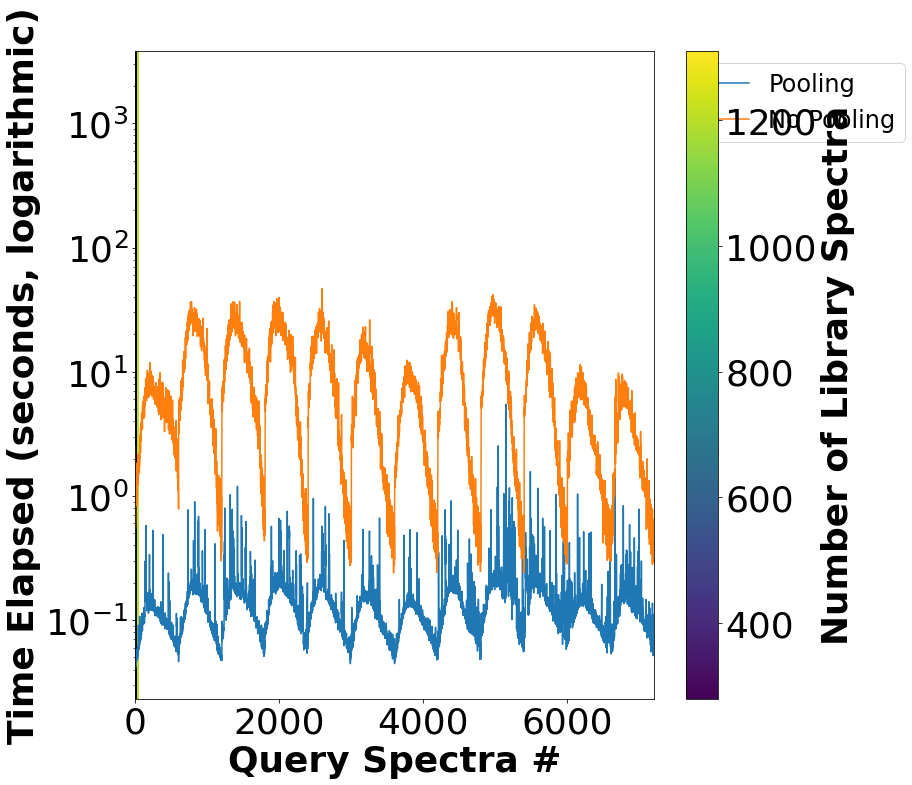

In [54]:
tempDf = pd.concat([pool,noPool])
#tempDf['TimeElapsed'] = tempDf['TimeElapsed'].apply(lambda x: math.log(x))
graph = tempDf.pivot(index='Index', columns='outputFile', values='TimeElapsed')
set_plot_settings('Query Spectra #', 'Time Elapsed (seconds, logarithmic)')
axes = pyplot.gca()
axes.set_yscale('log')
#pyplot.ylim(0,50)
pyplot.xlim(0,7200)
pyplot.plot(graph.index,graph['Data/Output/csodiaq_lib-human-20peaks-noloss-pt2mz-400to2000_exp-n1b.csv'], label='Pooling')
pyplot.plot(graph.index,graph['Data/Output/csodiaq_lib-human-6peaks-noloss-pt2mz-400to2000_exp-n1b.csv'], label='No Pooling')
#tempDf.plot.line(x="Index",y="NumPeaks",title="Number of Peaks Per Query Spectra, Sequentially")
pyplot.legend(bbox_to_anchor=(1.05, 1), loc='upper left', prop=fontP)
pyplot.savefig('Figure2C.svg')

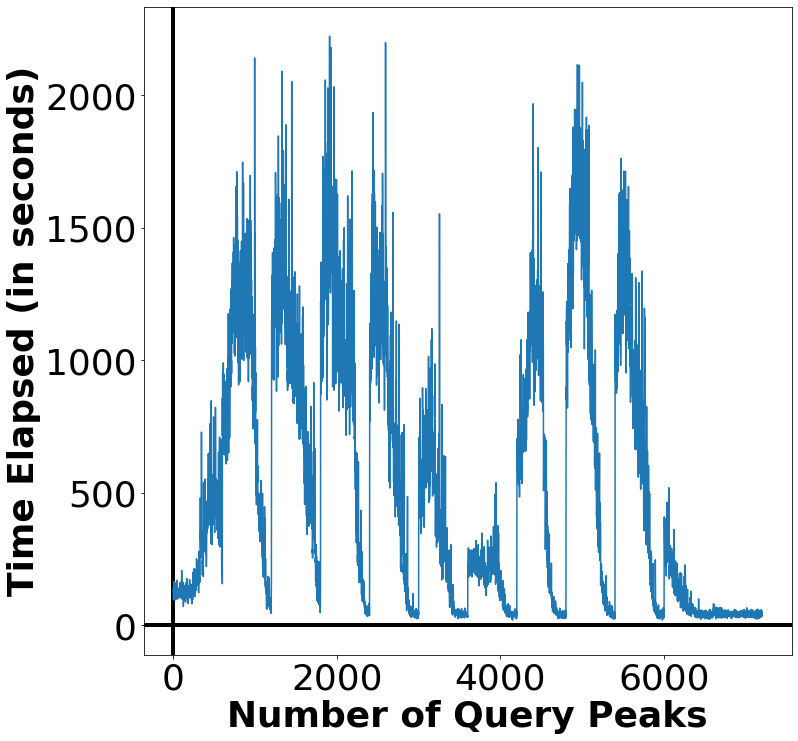

In [25]:
graph = pool.pivot(index='Index', columns='outputFile', values='NumPeaks')
set_plot_settings('Number of Query Peaks', 'Time Elapsed (in seconds)')

pyplot.plot(graph.index,graph['Data/Output/csodiaq_lib-human-20peaks-noloss-pt2mz-400to2000_exp-n1b.csv'])

280
1310


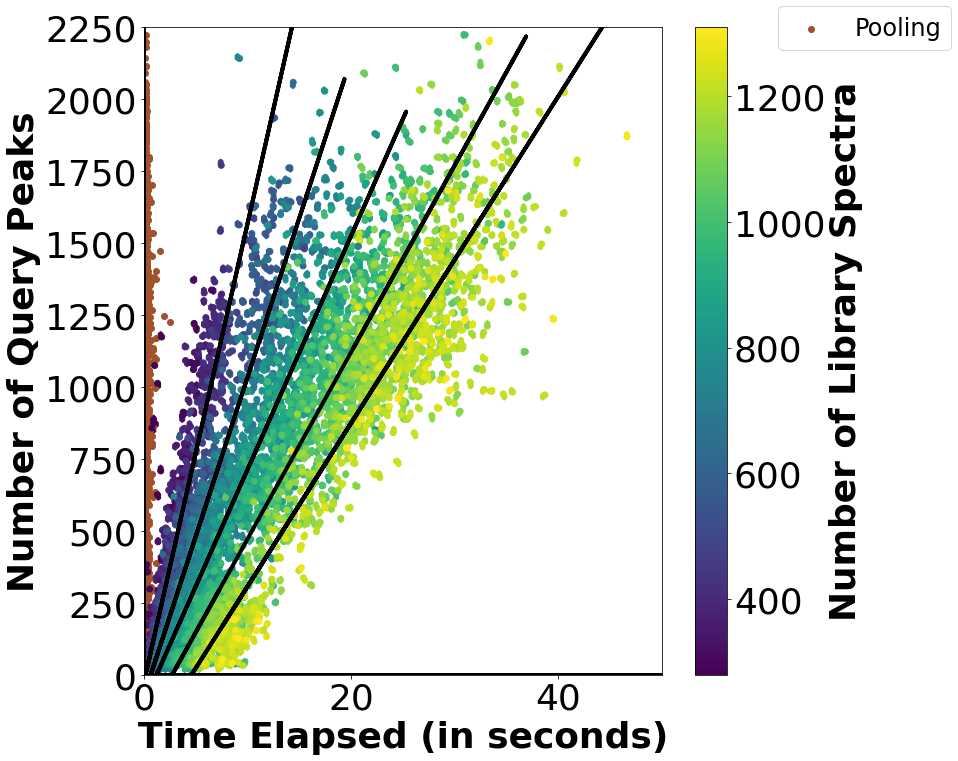

In [53]:
set_plot_settings('Time Elapsed (in seconds)', 'Number of Query Peaks')

pyplot.scatter(pool['TimeElapsed'],pool['NumPeaks'], label = 'Pooling', c = '#A0522D')
pyplot.scatter(noPool['TimeElapsed'],noPool['NumPeaks'], c=noPool['NumLibrarySpectra'])
#pyplot.legend(bbox_to_anchor=(1.05, 1), loc='upper left', prop=fontP)
noPool = noPool.sort_values('NumLibrarySpectra').reset_index(drop=True)

num = 5
sub = len(noPool)//num
for i in range(num):
    if i+1 == num: tempDf = noPool.loc[i*sub:]
    else: tempDf = noPool.loc[i*sub:(i+1)*sub]
    m, b = np.polyfit(tempDf['TimeElapsed'],tempDf['NumPeaks'], 1)
    pyplot.plot(tempDf['TimeElapsed'], m*tempDf['TimeElapsed'] + b, linewidth=4, color='black')


pyplot.ylim(0,2250)
pyplot.xlim(0,50)
pyplot.legend(bbox_to_anchor=(1.2, 1.05), loc='upper left', prop=fontP)

print(min(noPool['NumLibrarySpectra']))
print(max(noPool['NumLibrarySpectra']))
pyplot.savefig('Figure2B.svg')

(0.0, 50.0)

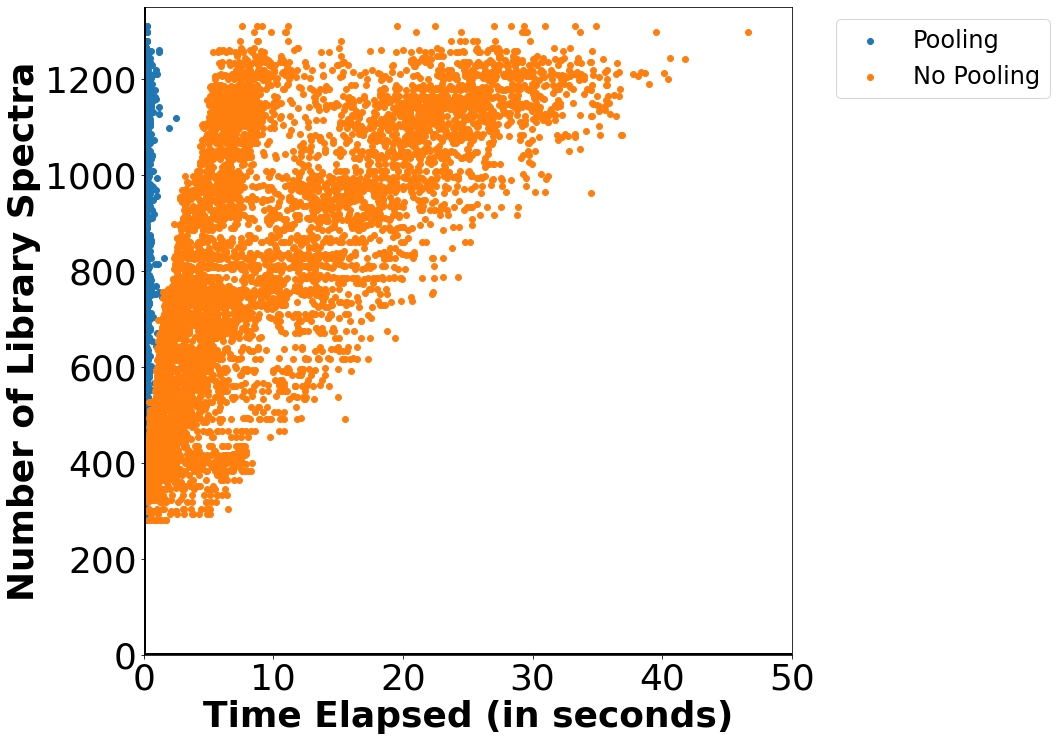

In [27]:
set_plot_settings('Time Elapsed (in seconds)', 'Number of Library Spectra')
pyplot.scatter(pool['TimeElapsed'],pool['NumLibrarySpectra'], label='Pooling')
pyplot.scatter(noPool['TimeElapsed'],noPool['NumLibrarySpectra'], label='No Pooling')
pyplot.legend(bbox_to_anchor=(1.05, 1), loc='upper left', prop=fontP)
pyplot.ylim(0,1350)
pyplot.xlim(0,50)

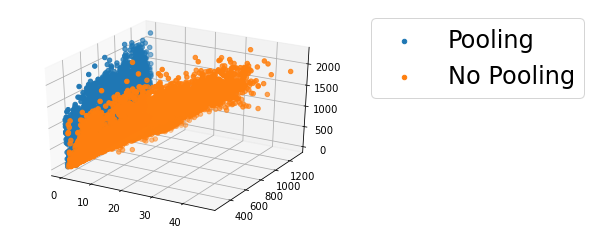

In [28]:
#%matplotlib notebook

fig = pyplot.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.set_xscale('log')


#set_plot_settings('Time Elapsed (in seconds)', 'Number of Library Spectra')
ax.scatter(pool['TimeElapsed'],pool['NumLibrarySpectra'],pool['NumPeaks'], label='Pooling')
ax.scatter(noPool['TimeElapsed'],noPool['NumLibrarySpectra'],noPool['NumPeaks'], label='No Pooling')
pyplot.legend(bbox_to_anchor=(1.05, 1), loc='upper left', prop=fontP)

#pyplot.ylim(0,1350)
#pyplot.xlim(0,50)

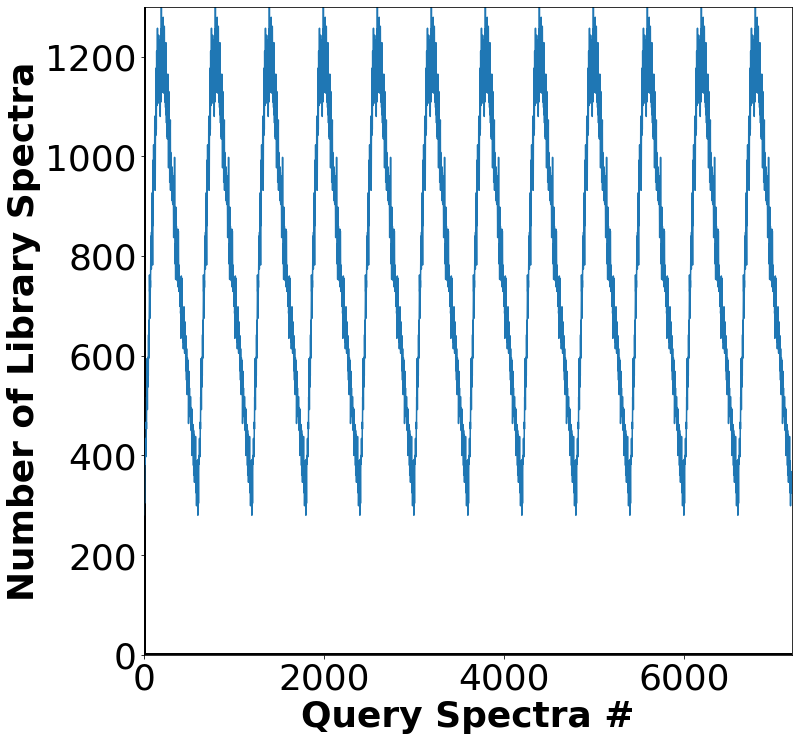

In [29]:
graph = pool.pivot(index='Index', columns='outputFile', values='NumLibrarySpectra')
set_plot_settings('Query Spectra #', 'Number of Library Spectra')
pyplot.ylim(0,1300)
pyplot.xlim(0,7200)
pyplot.plot(graph.index,graph['Data/Output/csodiaq_lib-human-20peaks-noloss-pt2mz-400to2000_exp-n1b.csv'])

## Venn Diagrams

In [30]:
caleb_peptide_df = pd.read_csv('Data/Output/csodiaq_lib-human-noloss-400to2000-pt2mz_31peaks_exp-n1b_corrected_peptideFDR.csv')
caleb_protein_df = pd.read_csv('Data/Output/csodiaq_lib-human-noloss-400to2000-pt2mz_31peaks_exp-n1b_corrected_proteinFDR.csv')
jesse_peptide_df = pd.read_csv('Data/Input/peptide_matches_Jesse.csv')
jesse_protein_df = pd.read_csv('Data/Input/protein_matches_Jesse.csv')

caleb_peptides = sorted(list(caleb_peptide_df['peptide']))
caleb_proteins = sorted(list(set(caleb_protein_df['leadingProtein'])),reverse=True)
jesse_peptides = sorted(list(jesse_peptide_df['Peptide']))
jesse_proteins = sorted(list(jesse_protein_df['Protein']))

#print(caleb_peptides[:10])
#print(jesse_peptides[:10])
#print(caleb_proteins[:10])
#print(jesse_proteins[:10])

#UniMod:1 = +42.01057
#UniMod:4 = +57.0215
#UniMod:5 = +43.0058
#UniMod:35 = +15.9949


unimodDict = {
    '(UniMod:4)':'+57.0215',
    '(UniMod:5)':'+42.01057',
    '(UniMod:35)':'+15.9949'
}

for i in range(len(caleb_peptides)):
    caleb_peptides[i] = re.sub('\(UniMod:\d+\)','',caleb_peptides[i])

caleb_peptides = list(set(caleb_peptides))
for i in range(len(jesse_peptides)):
    jesse_peptides[i] = re.sub('\+\d+\.\d+','',jesse_peptides[i])
jesse_peptides = list(set(jesse_peptides))

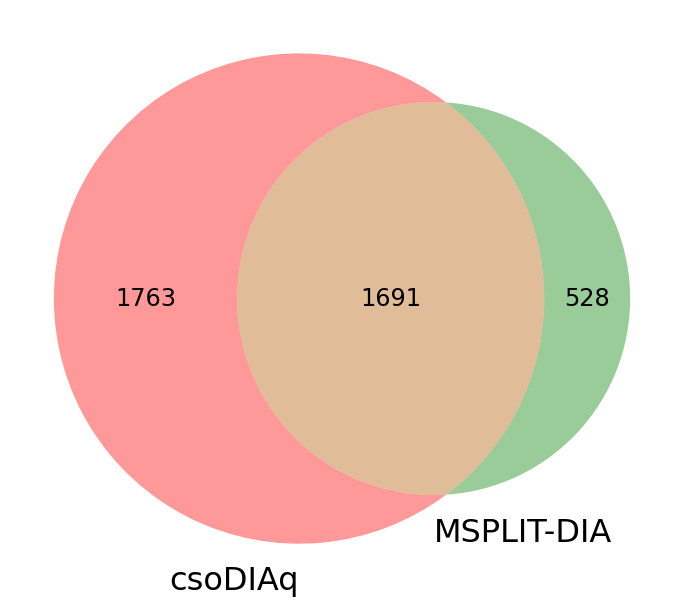

In [31]:
pyplot.figure(figsize=(12,12))
out = venn2([set(caleb_peptides),set(jesse_peptides)], set_labels = ["csoDIAq", "MSPLIT-DIA"])
for text in out.set_labels:
    text.set_fontsize(32)
for text in out.subset_labels:
    text.set_fontsize(24)
pyplot.show()

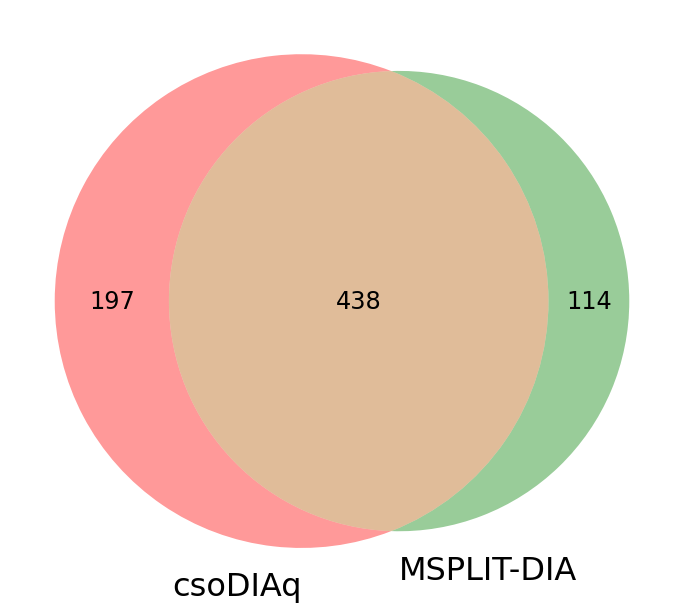

In [32]:
caleb_proteins1 = [re.sub('(\d+/)(DECOY_0_)?(sp\|\w{6}\|)', r'\2\3', x) for x in caleb_proteins if (x[0]+x[1])=='1/']
caleb_proteins = caleb_proteins1 + [x for x in caleb_proteins if (x[0]+x[1])!='1/']
jesse_proteins = [re.sub('(.*)(DECOY_0_)?(sp\|\w{6}\|)(.*)', r'\2\3', x) for x in jesse_proteins]
pyplot.figure(figsize=(12,12))
out = venn2([set(caleb_proteins),set(jesse_proteins)], set_labels = ["csoDIAq", "MSPLIT-DIA"])
for text in out.set_labels:
    text.set_fontsize(32)
for text in out.subset_labels:
    text.set_fontsize(24)
pyplot.show()

## Library Concept

In [33]:
def genTestData( mz_num , highpeak_num , lowpeak_num ):
    # mz_num number of sorted values between 56 and 1400 to replicate m/z
    mz = sorted( [ rand.uniform( 56 , 1400 ) for i in range( mz_num ) ] )
    
    # highpeak_num number of values between 2000 and 8000 to replicate high intensity peaks, lowpeak_num number of values between 50 and 2000 to replicate low intensity peaks
    intensity = [ rand.uniform( 2000 , 8000 ) for i in range( highpeak_num ) ] + [ rand.uniform( 50 , 2000 ) for i in range( lowpeak_num ) ]
    
    # intensities randomized
    rand.shuffle( intensity )

    # return as a pandas data frame
    return pd.DataFrame( [ intensity ] , columns = mz )

mz_num = 100
highpeak_num = 20
lowpeak_num = 80


def plot_spec(SPECTRA, COLOR):
    pyplot.vlines(SPECTRA.columns, np.repeat(0, len(SPECTRA.columns)), SPECTRA, colors=COLOR)
#    pyplot.ylim(-8000,8000)
    ax = pyplot.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

In [34]:
spec1 = genTestData( mz_num , highpeak_num , lowpeak_num )
spec1

# reference spectrum that is expected to match the experimental spectrum
# (reference spectra will contain 15 peaks)
refSpec1 = spec1.sample( mz_num//5 , axis=1 )
refSpec1 = refSpec1.sort_index( axis = 1 )

refSpec2 = spec1.sample( mz_num//5 , axis=1 )
refSpec2 = refSpec2.sort_index( axis = 1 )
refSpec3 = spec1.sample( mz_num//5 , axis=1 )
refSpec3 = refSpec3.sort_index( axis = 1 )
refSpec4 = spec1.sample( mz_num//5 , axis=1 )
refSpec4 = refSpec4.sort_index( axis = 1 )
refSpec5 = spec1.sample( mz_num//5 , axis=1 )
refSpec5 = refSpec5.sort_index( axis = 1 )
refSpec5

280.812490   344.235742   448.058813   495.475652   659.803121   \
0    241.49678  1491.687962   776.648837  1010.329656   404.814553   

   750.325135   811.761932   813.227329   841.418894   892.855642   \
0  2735.704661  1757.418775   860.393997  1451.517419  1921.682881   

   922.487466   947.580915   974.332994   1156.012177  1168.542674  \
0  1384.034731    467.05563  1173.145238  1227.776621   275.029199   

   1204.106640  1231.698693  1241.631206  1272.175403  1320.279987  
0   374.095798  1340.508995  1163.881005  1159.109611    816.81953

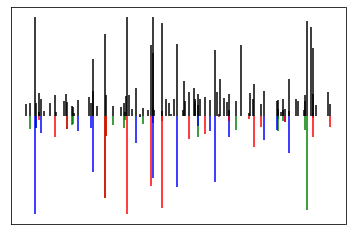

In [59]:
plot_spec(-refSpec1, 'green')
plot_spec(-refSpec2, 'blue')
plot_spec(-refSpec3, 'red')
plot_spec(spec1, 'black')
pyplot.savefig('Figure1-5.svg')

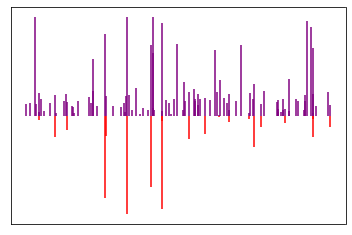

In [36]:
plot_spec(-refSpec3, 'red')
plot_spec(spec1, 'purple')

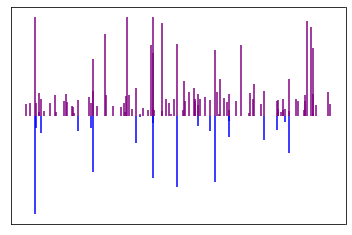

In [37]:
plot_spec(-refSpec2, 'blue')
plot_spec(spec1, 'purple')

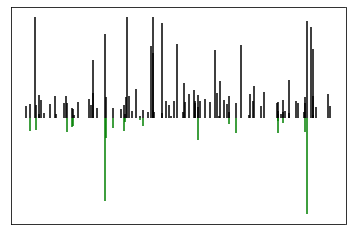

In [38]:
plot_spec(-refSpec1, 'green')
plot_spec(spec1, 'black')

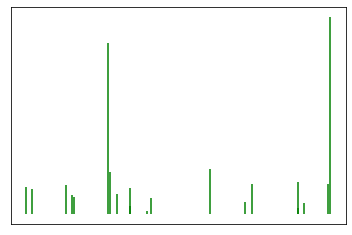

In [56]:
plot_spec(refSpec1, 'green')
pyplot.savefig('Figure1-2.svg')

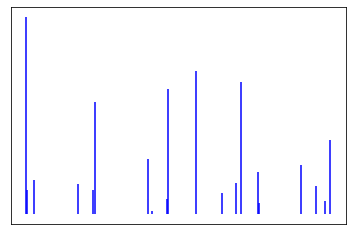

In [57]:
plot_spec(refSpec2, 'blue')
pyplot.savefig('Figure1-3.svg')

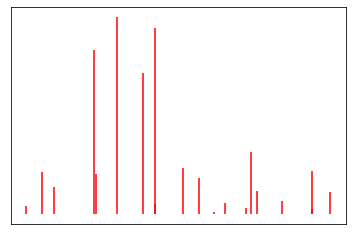

In [58]:
plot_spec(refSpec3, 'red')
pyplot.savefig('Figure1-4.svg')

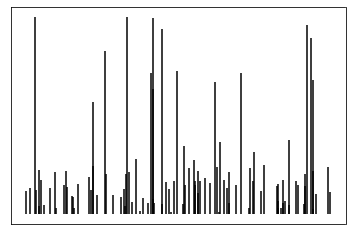

In [55]:
plot_spec(spec1, 'black')
pyplot.savefig('Figure1-1.svg')

In [43]:
mz = [2,4,6,12,14,16,33,35,37,43,45,47]
Heavy = [0, 0, 0, 20, 14, 6, 0, 0, 0, 16, 10, 4]
TallLight = [20, 14, 6, 0, 0, 0, 16, 10, 4, 0, 0, 0]
ShortLight = [5, 3, 1, 0, 0, 0, 4, 2, 1, 0, 0, 0]

heavyDf = pd.DataFrame([Heavy], columns=mz)
tallDf = pd.DataFrame([TallLight], columns=mz)
shortDf = pd.DataFrame([ShortLight], columns=mz)

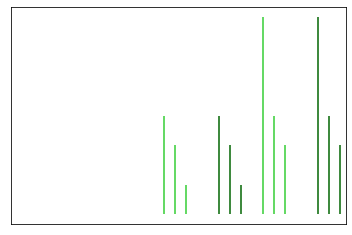

In [68]:
pyplot.xlim(0,61)
#plot_spec(heavyDf, '#000080')
#plot_spec(tallDf, '#00BFFF')
plot_spec(heavyDf, '#006400')
plot_spec(tallDf, '#32CD32')
pyplot.savefig('Figure1-7.svg')

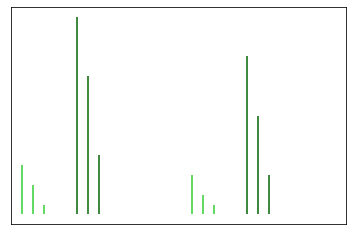

In [45]:
pyplot.xlim(0,61)
#plot_spec(heavyDf, '#000080')
#plot_spec(shortDf, '#00BFFF')
plot_spec(heavyDf, '#006400')
plot_spec(shortDf, '#32CD32')

In [64]:
#mz = [5,7,9,15,17,19,28,30,32,38,40,42,46,48,50,56,58,60]
#Heavy = [0, 0, 0, 30, 22, 10, 0, 0, 0, 20, 14, 6, 0, 0, 0, 40, 20, 14]
#TallLight = [30, 22, 10, 0, 0, 0, 20, 14, 6, 0, 0, 0, 40, 20, 14, 0, 0, 0 ]
#ShortLight = [8, 5, 2, 0, 0, 0, 5, 3, 1, 0, 0, 0, 10, 5, 3, 0, 0, 0 ]

mz = [28,30,32,38,40,42,46,48,50,56,58,60]
Heavy = [0, 0, 0, 20, 14, 6, 0, 0, 0, 40, 20, 14]
TallLight = [20, 14, 6, 0, 0, 0, 40, 20, 14, 0, 0, 0 ]
ShortLight = [5, 3, 1, 0, 0, 0, 10, 5, 3, 0, 0, 0 ]


heavyDf = pd.DataFrame([Heavy], columns=mz)
tallDf = pd.DataFrame([TallLight], columns=mz)
shortDf = pd.DataFrame([ShortLight], columns=mz)

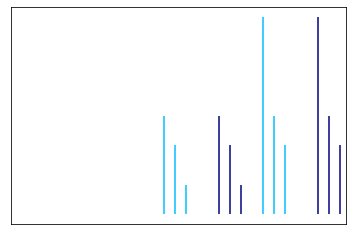

In [65]:
pyplot.xlim(0,61)
plot_spec(heavyDf, '#000080')
plot_spec(tallDf, '#00BFFF')

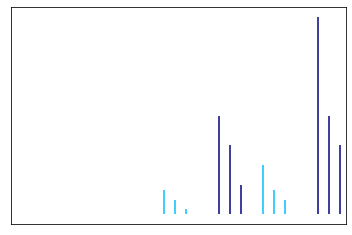

In [69]:
pyplot.xlim(0,61)
plot_spec(heavyDf, '#000080')
plot_spec(shortDf, '#00BFFF')
pyplot.savefig('Figure1-8.svg')